In [22]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
from tkinter import Tk, filedialog
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
# Function to select the CSV file
def choose_csv():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    return file_path

In [24]:

# Function to select multiple video files
def choose_videos():
    root = Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(filetypes=[("Video files", "*.mp4;*.avi")])
    return file_paths

In [25]:
# Function to calculate mAP@0.5
def calculate_map_50(actual_counts, predicted_counts, iou_threshold=0.5):
    correct_predictions = 0
    for actual, pred in zip(actual_counts, predicted_counts):
        if actual == 0:  # Avoid division by zero
            if pred == 0:
                correct_predictions += 1
        else:
            diff = abs(actual - pred) / actual
            if diff <= (1 - iou_threshold): 
                correct_predictions += 1
    
    map_50 = correct_predictions / len(actual_counts) if len(actual_counts) > 0 else 0
    return map_50


In [31]:
# Load CSV file with actual counts
csv_path = choose_csv()
if not csv_path:
    print("No CSV file selected. Exiting.")
    exit()

In [32]:
# Read the CSV file
df = pd.read_csv(csv_path)
print(f"CSV file loaded: {csv_path}")
print(df.head())


CSV file loaded: C:/Users/SANSKRITI SAHU/Downloads/people_count_evaluation.csv
  Video Number  actual_count  predicted_count
0      vid (1)             5                0
1      vid (2)             2                0
2      vid (3)             1                0
3      vid (4)            12                0
4      vid (5)            18                0


In [28]:
# Get video file paths
video_paths = choose_videos()
if not video_paths:
    print("No videos selected. Exiting.")
    exit()
print(f"Videos selected: {video_paths}")


Videos selected: ('C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (1).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (2).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (3).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (4).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (5).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (6).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (7).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (8).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (9).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (10).mp4', 'C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (11).mp4')


In [41]:
# Loading model
model = YOLO("yolov8x.pt")

In [35]:
# Create a new column for predicted counts
df['predicted_count'] = 0
video_predictions = {}

# Process each video and update predicted counts
for video_path in video_paths:
    # Extract video basename for matching with CSV
    video_basename = os.path.basename(video_path)
    video_name = os.path.splitext(video_basename)[0]
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Only process the first 5 frames
    frame_limit = min(5, frame_count)

    # Prepare output video file path
    output_path = f"annotated_{video_basename}"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Processing video: {video_path}")
    print(f"Video resolution: {width}x{height}, FPS: {fps}, Total frames: {frame_count}")
    
    box_annotator = sv.BoxAnnotator()
    
    # List to store people counts for each frame
    frame_counts = []

    # Process only first 5 frames
    for _ in tqdm(range(frame_limit), desc=f"Processing {video_basename} (First 5 Frames)"):
        ret, frame = cap.read()
        if not ret:
            break

       
        results = model(frame, classes=0, verbose=False)[0]

        # Extract bounding boxes
        xyxy = results.boxes.xyxy.cpu().numpy()
        conf = results.boxes.conf.cpu().numpy()
        class_ids = results.boxes.cls.cpu().numpy().astype(int)

        detections = sv.Detections(xyxy=xyxy, confidence=conf, class_id=class_ids)

        annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

        people_count = len(detections)
        frame_counts.append(people_count)
        
        cv2.putText(annotated_frame, f"People Count: {people_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        out.write(annotated_frame)

    # Use max count across first 5 frames
    if frame_counts:
        final_count = max(frame_counts)

        # Update DataFrame
        if video_name in df['Video Number'].values or video_basename in df['Video Number'].values:
            if video_name in df['Video Number'].values:
                idx = df[df['Video Number'] == video_name].index
                df.loc[idx, 'predicted_count'] = final_count
            elif video_basename in df['Video Number'].values:
                idx = df[df['Video Number'] == video_basename].index
                df.loc[idx, 'predicted_count'] = final_count
            else:
                for vid in df['Video Number']:
                    if vid in video_name or video_name in vid:
                        idx = df[df['Video Number'] == vid].index
                        df.loc[idx, 'predicted_count'] = final_count
                        break

    cap.release()
    out.release()
    print(f"✅ Annotated video saved as: {output_path}")


Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (1).mp4
Video resolution: 1280x720, FPS: 29, Total frames: 330


Processing vid (1).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


✅ Annotated video saved as: annotated_vid (1).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (2).mp4
Video resolution: 768x432, FPS: 50, Total frames: 487


Processing vid (2).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


✅ Annotated video saved as: annotated_vid (2).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (3).mp4
Video resolution: 640x360, FPS: 25, Total frames: 255


Processing vid (3).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


✅ Annotated video saved as: annotated_vid (3).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (4).mp4
Video resolution: 498x210, FPS: 10, Total frames: 14


Processing vid (4).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


✅ Annotated video saved as: annotated_vid (4).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (5).mp4
Video resolution: 640x480, FPS: 25, Total frames: 91


Processing vid (5).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


✅ Annotated video saved as: annotated_vid (5).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (6).mp4
Video resolution: 320x240, FPS: 14, Total frames: 56


Processing vid (6).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


✅ Annotated video saved as: annotated_vid (6).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (7).mp4
Video resolution: 480x204, FPS: 15, Total frames: 16


Processing vid (7).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


✅ Annotated video saved as: annotated_vid (7).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (8).mp4
Video resolution: 220x178, FPS: 8, Total frames: 28


Processing vid (8).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]


✅ Annotated video saved as: annotated_vid (8).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (9).mp4
Video resolution: 220x170, FPS: 10, Total frames: 31


Processing vid (9).mp4 (First 5 Frames): 100%|███████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


✅ Annotated video saved as: annotated_vid (9).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (10).mp4
Video resolution: 1920x1080, FPS: 25, Total frames: 767


Processing vid (10).mp4 (First 5 Frames): 100%|██████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


✅ Annotated video saved as: annotated_vid (10).mp4
Processing video: C:/Users/SANSKRITI SAHU/Downloads/Videos/vid (11).mp4
Video resolution: 640x360, FPS: 25, Total frames: 393


Processing vid (11).mp4 (First 5 Frames): 100%|██████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]

✅ Annotated video saved as: annotated_vid (11).mp4


In [36]:
# Save the updated DataFrame to a new CSV file
output_csv = "crowd_detection_results.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Results saved to: {output_csv}")

✅ Results saved to: crowd_detection_results.csv


In [40]:
df.head()

,Video Number,actual_count,predicted_count
0,vid (1),5,8
1,vid (2),2,2
2,vid (3),1,1
3,vid (4),12,14
4,vid (5),18,15



Evaluation Metrics:
Mean Absolute Error (MAE): 2.36
Root Mean Squared Error (RMSE): 3.41
R² Score: 0.55
mAP@0.5: 0.73


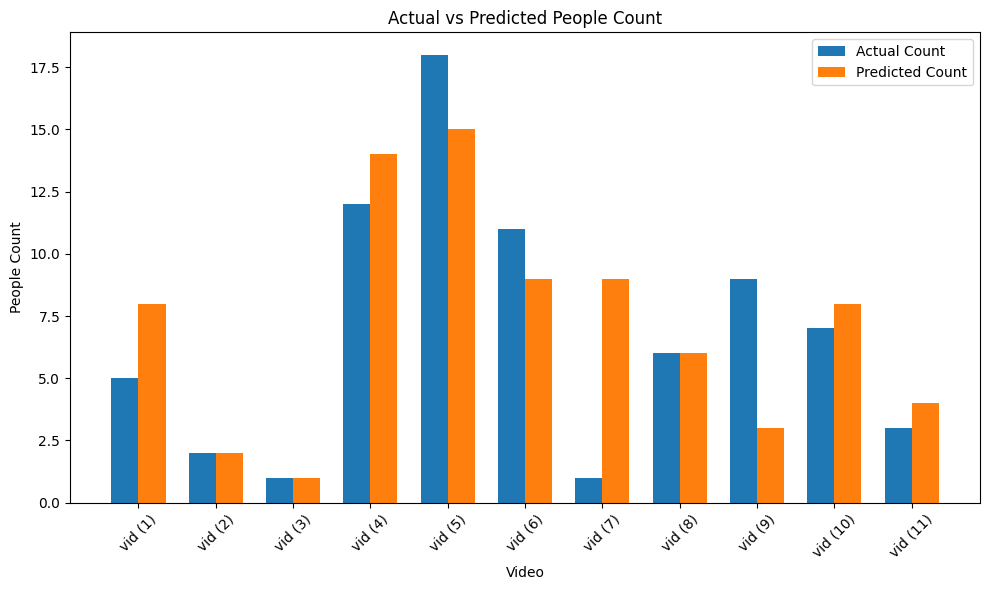

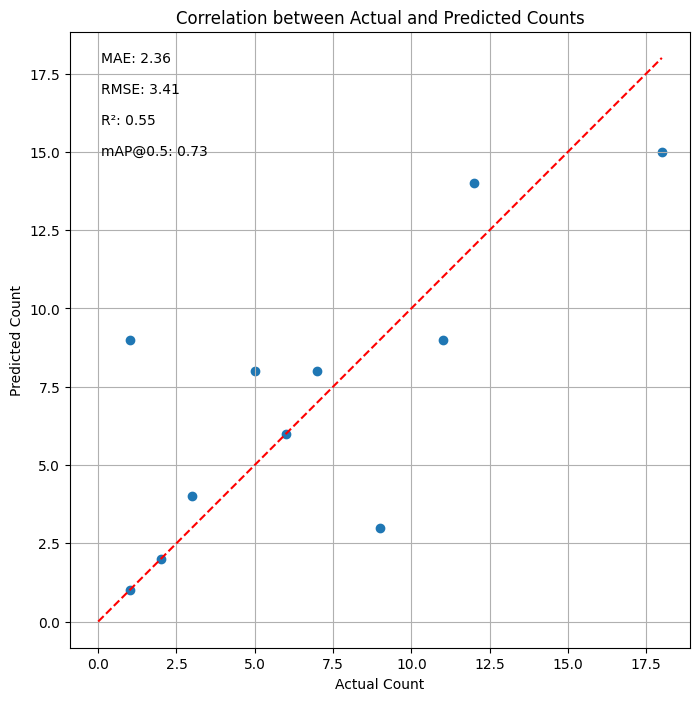

Process completed!


In [39]:
# Evaluate predictions
valid_data = df.dropna(subset=['actual_count', 'predicted_count'])

if len(valid_data) > 0:
    actual_counts = valid_data['actual_count'].values
    predicted_counts = valid_data['predicted_count'].values

    # Calculate metrics
    mae = mean_absolute_error(actual_counts, predicted_counts)
    rmse = np.sqrt(mean_squared_error(actual_counts, predicted_counts))
    r2 = r2_score(actual_counts, predicted_counts)
    map_50 = calculate_map_50(actual_counts, predicted_counts, iou_threshold=0.5)

    print("\nEvaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"mAP@0.5: {map_50:.2f}")

    # Creat visualization
    plt.figure(figsize=(10, 6))
    
    # Bar chart comparing actual vs predicted counts
    videos = valid_data['Video Number'].values
    x = np.arange(len(videos))
    width = 0.35
    
    plt.bar(x - width/2, actual_counts, width, label='Actual Count')
    plt.bar(x + width/2, predicted_counts, width, label='Predicted Count')
    
    plt.xlabel('Video')
    plt.ylabel('People Count')
    plt.title('Actual vs Predicted People Count')
    plt.xticks(x, videos, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('actual_vs_predicted_counts.png')
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(actual_counts, predicted_counts)
    
    # Add a perfect prediction line
    max_count = max(max(actual_counts), max(predicted_counts))
    plt.plot([0, max_count], [0, max_count], 'r--')
    
    plt.xlabel('Actual Count')
    plt.ylabel('Predicted Count')
    plt.title('Correlation between Actual and Predicted Counts')
    plt.grid(True)
    plt.axis('equal')
    
    # Add metrics to the plot
    plt.text(0.05, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.90, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.85, f'R²: {r2:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.80, f'mAP@0.5: {map_50:.2f}', transform=plt.gca().transAxes)
    
    # Save the figure
    plt.savefig('correlation_plot.png')
    plt.show()
else:
    print("No matching data found between videos and CSV records.")

print("Process completed!")